In [1]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


In [2]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [5]:
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['AMZN', 'GOOG']

In [6]:
news_tables = {}
for ticker in tickers:
    url = finviz_url + ticker

    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)

    html = BeautifulSoup(response, features='html.parser')
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table


In [12]:
parsed_data = []

for ticker, news_table in news_tables.items():
    if news_table is not None:
        last_date = None  # Initialize the last known date
        for row in news_table.findAll('tr'):
            title_element = row.a
            date_element = row.td

            if title_element and date_element:
                title = title_element.text
                date_data = date_element.text.strip().split(' ')

                if len(date_data) == 2:
                    last_date = date_data[0]  # Update the last known date
                    time = date_data[1]
                elif len(date_data) == 1:
                    time = date_data[0]

                parsed_data.append([ticker, last_date, time, title])

df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])

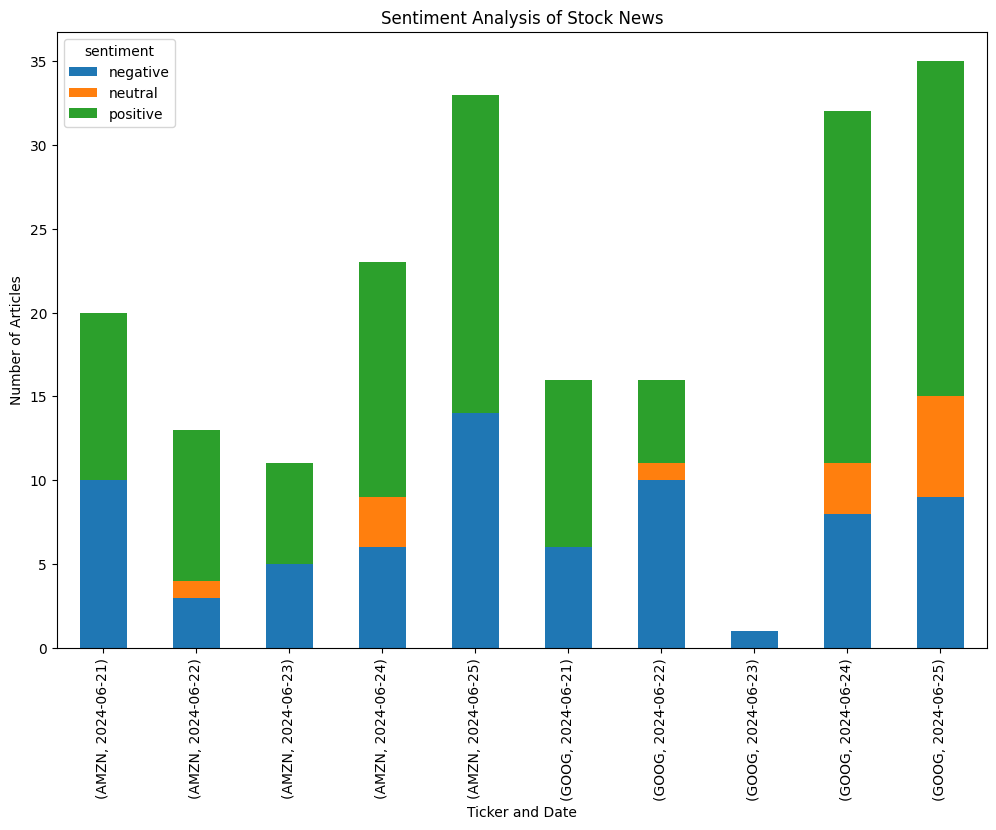

In [17]:
def get_sentiment_score(title):
    inputs = tokenizer(title, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    scores = outputs.logits.detach().numpy()
    sentiment = torch.argmax(torch.tensor(scores), dim=1).item() + 1
    if sentiment in [1, 2]:
        return 'negative'
    elif sentiment in [4, 5]:
        return 'positive'
    else:
        return 'neutral'

df['sentiment'] = df['title'].apply(get_sentiment_score)
df['date'] = pd.to_datetime(df.date).dt.date

# Count the number of positive and negative articles for each ticker and date
sentiment_counts = df.groupby(['ticker', 'date', 'sentiment']).size().unstack(fill_value=0)

# Plot the results
sentiment_counts.plot(kind='bar', figsize=(12, 8), stacked=True)
plt.title('Sentiment Analysis of Stock News')
plt.xlabel('Ticker and Date')
plt.ylabel('Number of Articles')
plt.show()